# Kupffer Analysis Data Processing

In [1]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import pandas as pd
import numpy as np
import matplotlib
import threading
import matplotlib.pyplot as plt 
import seaborn as sns
from collections import Counter
matplotlib.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(3000)
import pickle
from sklearn import preprocessing
import time
import inspect
sns.set_context('talk')

# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from plotting_scripts import pca_rpkm_mat

# Preprocessing

In [2]:
workingDirectory = '/home/h1bennet/liverStrains/results/181009_kupffer_ly6c_tba/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

## ATAC QC
requires tag directories

In [3]:
%%bash
if [ ! -d ./qc_atac/ ]; then mkdir ./qc_atac; fi

In [4]:
atac_qc = ngs_qc('./tag_directories_atac', 'atac')

/home/h1bennet/anaconda3/envs/tba/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


<Figure size 432x288 with 0 Axes>

## Create Script To Process ATAC tag directories


In [5]:
# renaming dict to make naming more consistant
rename_dict = {
    'NCoRWT_KupfferTim4Neg_ATAC_NASHDiet_21wk_AMLN_Flavopiridol_LN170B_TDT_JSS': 'ncorwt_kupffertim4neg_nashdiet_21wk_1',
    'NCoRWT_KupfferTim4Neg_ATAC_NASHDiet_21wk_AMLN_Flavopiridol_LN170C_TDT_JSS': 'ncorwt_kupffertim4neg_nashdiet_21wk_2',
    'NCoRWT_KupfferTim4Pos_ATAC_NASHDiet_21wk_AMLN_Flavopiridol_LN170B_TDT_JSS': 'ncorwt_kupffertim4pos_nashdiet_21wk_1',
    'NCoRWT_KupfferTim4Pos_ATAC_NASHDiet_21wk_AMLN_Flavopiridol_LN170C_TDT_JSS': 'ncorwt_kupffertim4pos_nashdiet_21wk_2',
    'C57B6J_BloodLy6cHi3_ATAC_NoTx_MS_20171119': 'ncorwt_bloodly6chi_controldiet_0wk_1',
    'C57B6J_BloodLy6cHi8_ATAC_NoTx_MS_20171119': 'ncorwt_bloodly6chi_controldiet_0wk_2',
    'C57BL6J_M_BloodLy6CHiMono_ATAC_20wkNASHDiet_rep1_JSSTDT_20180815': 'ncorwt_bloodly6chi_nashdiet_20wk_1',
    'C57BL6J_M_BloodLy6cHiMono_ATAC_20wkNASHDiet_rep2_JSSTDT_20180815': 'ncorwt_bloodly6chi_nashdiet_20wk_2',
    'C57BL6J_M_BloodLy6CLowMono_ATAC_20wkNASHDiet_rep1_JSSTDT_20180815': 'ncorwt_bloodly6clo_nashdiet_20wk_1',
    'C57BL6J_M_BloodLy6cLowMono_ATAC_20wkNASHDiet_rep2_JSSTDT_20180815': 'ncorwt_bloodly6clo_nashdiet_20wk_2',
    'c57bl6j_M_Ly6Chigh_ATAC_AMLN30Wk_C573A_TDT_JSS_s20171012': 'ncorwt_liverly6chi_nashdiet_30wk_1',
    'c57bl6j_M_Ly6Chigh_ATAC_AMLN30Wk_C573B_TDT_JSS_s20171012': 'ncorwt_liverly6chi_nashdiet_30wk_2',
    'c57bl6j_M_Ly6Clow_ATAC_AMLN30Wk_C573A_TDT_JSS_s20171012': 'ncorwt_liverly6clo_nashdiet_30wk_1',
    'c57bl6j_M_Ly6Clow_ATAC_AMLN30Wk_C573B_TDT_JSS_s20171012': 'ncorwt_liverly6clo_nashdiet_30wk_2',
    'c57bl6_Kupffer_ATAC_pooled_CR_TDT_16_01_19': 'ncorwt_kupffer_controldiet_0wk_1',
    'mouse_C57B6J_M_KupfferTim4Pos_ATAC_NoTx_JSSTDT165225Frag_C57e_JSS_l20170916_TAAGGCGA_S126_L006_R1_001': 'ncorwt_kupffer_controldiet_0wk_2'
}

### Performance summary

In [6]:
performance_dict = {}
for i in os.listdir('./abtba_output/'):
    if 'performance' in i:
        performance = pd.read_csv('./abtba_output/'+i, sep='\t')
        performance_dict[i] = (performance['Precision Score'].mean(), performance['ROC'].mean())

mean_performance = pd.DataFrame(performance_dict, index=['Precision', 'ROC'])

In [7]:
mean_performance.T

,Precision,ROC
ncorwt_bloodly6chi_controldiet_0wk_atac_idr_peaks_performance.tsv,0.865373,0.872951
ncorwt_bloodly6chi_nashdiet_20wk_atac_idr_peaks_performance.tsv,0.867924,0.875153
ncorwt_bloodly6clo_nashdiet_20wk_atac_idr_peaks_performance.tsv,0.870234,0.876918
ncorwt_kupffer_controldiet_0wk_atac_idr_peaks_performance.tsv,0.851556,0.857045
ncorwt_kupffertim4neg_nashdiet_21wk_atac_idr_peaks_performance.tsv,0.863650,0.869125
ncorwt_kupffertim4pos_nashdiet_21wk_atac_idr_peaks_performance.tsv,0.877041,0.882305
ncorwt_liverly6chi_nashdiet_30wk_atac_idr_peaks_performance.tsv,0.870169,0.877672
ncorwt_liverly6clo_nashdiet_30wk_atac_idr_peaks_performance.tsv,0.867772,0.875178


# Plots

In [8]:
# make folder for figures
if not os.path.isdir('./figures'):
    os.mkdir('./figures')

# define sample order for plotting
samp_order=['ncorwt_bloodly6chi_controldiet',
            'ncorwt_bloodly6clo_nashdiet',
            'ncorwt_bloodly6chi_nashdiet',
            'ncorwt_liverly6clo_nashdiet',
            'ncorwt_liverly6chi_nashdiet',
            'ncorwt_kupffer_controldiet',
            'ncorwt_kupffertim4neg_nashdiet',
            'ncorwt_kupffertim4pos_nashdiet']

### read in weight values

In [9]:
sample_weights_dict = {}
for f in os.listdir('./abtba_output/'):
    if 'coefficients' in f and not 'gene' in f:
        # read in coefficients
        frame = pd.read_csv('./abtba_output/' + f, sep='\t', index_col=0)
        # take the mean across cross validation iterations
        mean_weights = frame.mean(axis=1)
        sample = '_'.join(f.split('_')[0:3])
        sample_weights_dict[sample] = mean_weights
# create data frame
mean_weights_frame = pd.DataFrame(sample_weights_dict, index = sample_weights_dict[list(sample_weights_dict.keys())[0]].index.values)
mean_weights_frame = mean_weights_frame[mean_weights_frame.isnull().max(axis=1) ==False]

### read in significance values

In [10]:
sample_pval_dict = {}
for f in os.listdir('./abtba_output/'):
    if 'significance' in f and not 'gene' in f:
        # read in signifance values using pandas
        frame = pd.read_csv('./abtba_output/' + f, sep='\t', index_col=0)
        # take the mean across cross validation iterations
        mean_pval = frame.mean(axis=1) 
        sample = '_'.join(f.split('_')[0:3])
        sample_pval_dict[sample] = mean_pval
# create data frame
mean_pval_frame = pd.DataFrame(sample_pval_dict, index = sample_pval_dict[list(sample_pval_dict.keys())[0]].index.values)
mean_pval_frame = mean_pval_frame[mean_pval_frame.isnull().max(axis=1) ==False]

### Plot all Motifs Significance values

/home/h1bennet/anaconda3/envs/tba/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


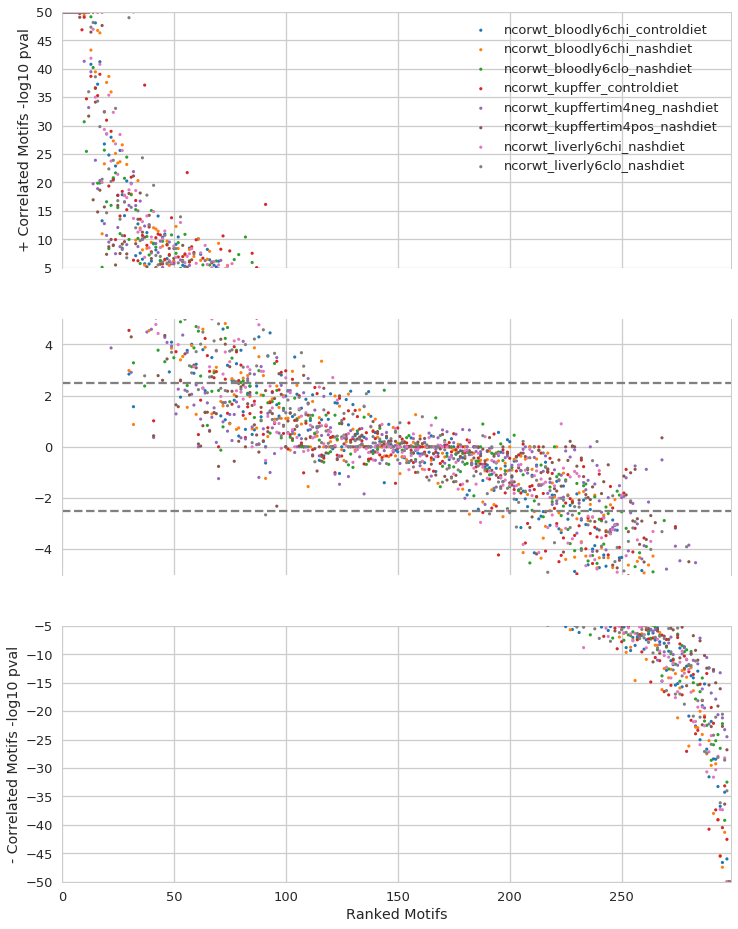

In [11]:
pseudocount = 1e-50 # set ceiling/floor for pvals
treatments = mean_pval_frame.columns
pval_threshold = 10**-2.5 # position of the dashed lines
treatment_orientedPvals_dict = {}
for treatment in treatments:
    pvals = mean_pval_frame[treatment]
    weights = mean_weights_frame[treatment]
    # calculate logpvals and assign direction according to weight
    oriented_pvals = [np.log10(x[0] +pseudocount) if x[1] < 0 else -np.log10(x[0]+pseudocount) for x in zip(pvals, weights)]
    treatment_orientedPvals_dict[treatment] = oriented_pvals

    # create data frame and sort according to mean
frame = pd.DataFrame(treatment_orientedPvals_dict, index = mean_pval_frame.index.values)
frame['mean'] = frame.mean(axis=1)
frame.sort_values('mean', ascending = False, inplace=True)
frame.drop('mean', axis=1, inplace=True)

colors = sns.color_palette()
counter = 0
with sns.axes_style('whitegrid'):
    # define subplots
    f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize = (12,16))

    for treatment in frame.columns.values:
        color = colors[counter]
        counter += 1
        # top panel
        # bottom panel
        ax1.scatter(list(range(frame.shape[0])), 
                    frame[treatment], 
                    label = treatment, 
                    c = color,
                    marker = 'o',
                    edgecolor = 'None',
                    s=10)
        
        # middle panel
        ax2.scatter(list(range(frame.shape[0])), 
                    frame[treatment], 
                    label = treatment, 
                    c = color,
                    marker = 'o',
                    edgecolor = 'None',
                    s=10)
        # bottom panel
        ax3.scatter(list(range(frame.shape[0])), 
                    frame[treatment], 
                    label = treatment, 
                    c = color,
                    marker = 'o',
                    edgecolor = 'None',
                    s=10)
        
    # scale panels
    plt.xlim(0,299)
    ax1.set_ylim(5, 50)
    ax2.set_ylim(-5, 5)  
    ax3.set_ylim(-50,-5)
    
    # hide the spines between axes
    ax1.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    
    ax2.spines['bottom'].set_visible(False)
    ax3.spines['top'].set_visible(False)
    
    ax1.xaxis.tick_top()
    ax1.tick_params(labeltop='off')  # don't put tick labels at the top
    
    ax3.xaxis.tick_bottom()
    
    ax2.axhline(xmin=0,xmax=299,y=-np.log10(pval_threshold+ pseudocount), c='grey', linestyle='--')
    ax2.axhline(xmin=0,xmax=299,y=np.log10(pval_threshold+ pseudocount), c='grey', linestyle='--')
    
    ax1.set_ylabel('+ Correlated Motifs -log10 pval')
    ax3.set_ylabel('- Correlated Motifs -log10 pval')
    ax1.legend()
    
    plt.xlabel('Ranked Motifs')


### dict to rename rows with the motif sets

In [12]:
merged_motif_dict = {}

with open('/home/h1bennet/code/abtba/motif_metadata.tsv', 'r') as f:
    f.readline()
    for i in f.readlines():
        fields = i.split()
        if 'merged' in fields[0]:
            merged_motif_dict[fields[0]]=fields[1]

### PCA with Motif weights

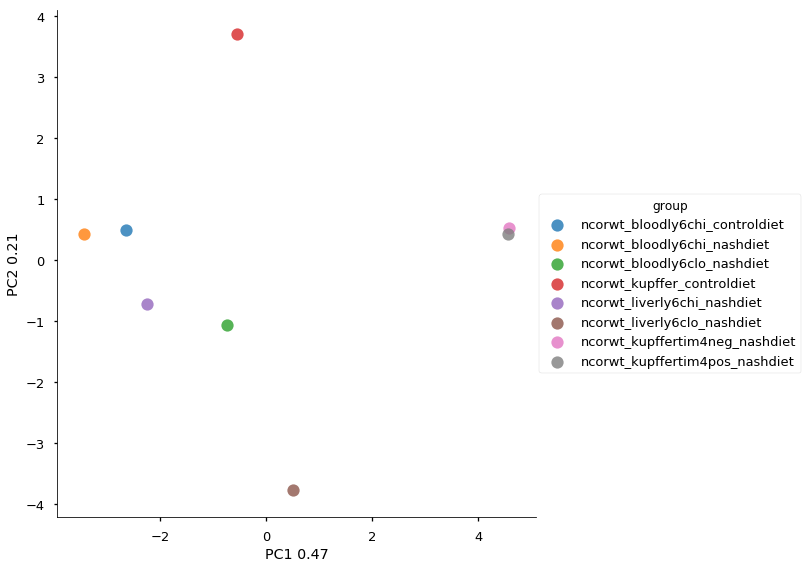

In [13]:
pseudocount = 1e-50 # pseudocount for calculating logfold change
treatments = mean_pval_frame.columns
treatment_orientedPvals_dict = {}
for treatment in treatments:
    # retrieve pval and weights cooresponding to treatment
    pvals = mean_pval_frame[treatment]
    weights = mean_weights_frame[treatment]
    # calculate logpvals and assign direction according to weight
    oriented_pvals = [np.log10(x[0] +pseudocount) if x[1] < 0 else -np.log10(x[0]+pseudocount) for x in zip(pvals, weights)]
    treatment_orientedPvals_dict[treatment] = oriented_pvals
    
# create data frame
frame = pd.DataFrame(treatment_orientedPvals_dict, index = mean_pval_frame.index.values)

# sort by mean
frame['mean'] = frame.mean(axis=1)
frame.sort_values('mean', ascending = False, inplace=True)
frame.drop('mean', axis=1, inplace=True)

pca = pca_rpkm_mat(rpkm=frame.iloc[:, [0,1,2,3,6,7,4,5]], group_labels=frame.iloc[:, [0,1,2,3,6,7,4,5]].columns.values, n_pca=5)

### Top 20 Average Motif Significance

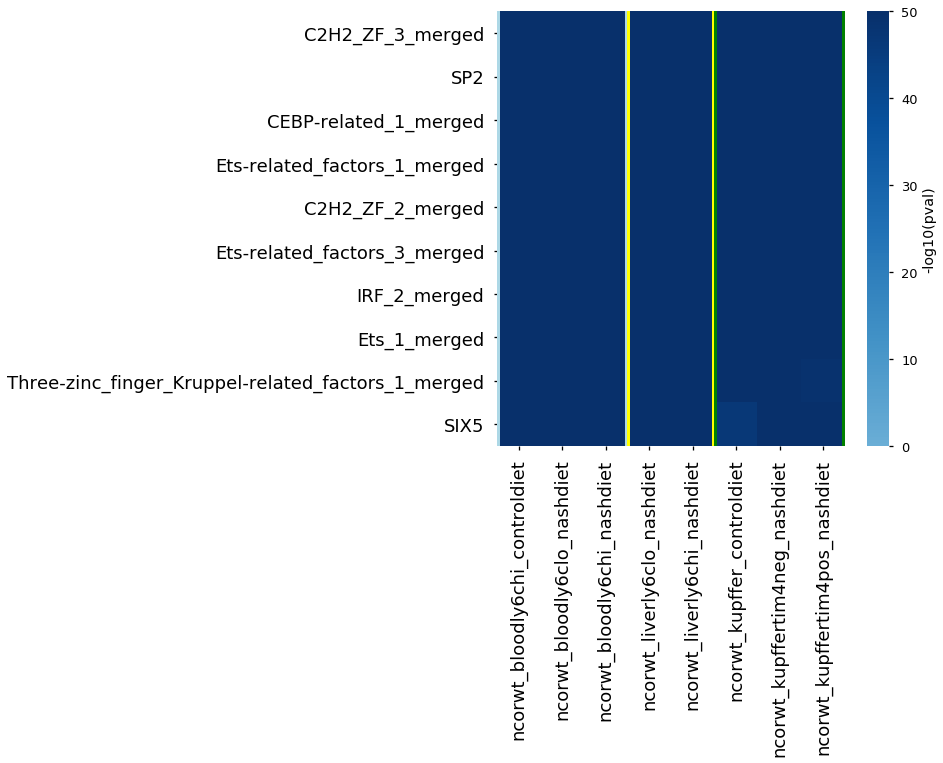

In [31]:
pseudocount = 1e-50 # pseudocount for calculating logfold change
treatments = mean_pval_frame.columns
# treatment_orientedPvals_dict = {}
for treatment in treatments:
    # retrieve pval and weights cooresponding to treatment
    pvals = mean_pval_frame[treatment]
    weights = mean_weights_frame[treatment]
    
    # calculate logpvals and assign direction according to weight
    oriented_pvals = [np.log10(x[0] +pseudocount) if x[1] < 0 else -np.log10(x[0]+pseudocount) for x in zip(pvals, weights)]
    treatment_orientedPvals_dict[treatment] = oriented_pvals
    
# create data frame
frame = pd.DataFrame(treatment_orientedPvals_dict, index = mean_pval_frame.index.values)
# sort by mean
frame['mean'] = frame.mean(axis=1)
frame.sort_values('mean', ascending = False, inplace=True)
frame.drop('mean', axis=1, inplace=True)

frame = frame.iloc[:10, :].loc[:, samp_order]
# frame = frame.rename(merged_motif_dict, axis='index')

# create heatmap
fig, ax = plt.subplots(figsize=(8,8))
hm = sns.heatmap(
    frame,
    center=0,
    vmin=0,
    cbar_kws={'label': '-log10(pval)'},
    square=True,
    cmap='Blues',
    ax=ax)
pos = hm.get_position()

hm.set_yticklabels(size=18, labels = frame.index.values);
hm.set_xticklabels(size=18, labels = frame, rotation=90);

# draw lines to separate groups
plt.plot([.025, .025], [0, 100], linewidth=3, color='lightblue');
plt.plot([2.975, 2.975], [0, 100], linewidth=3, color='lightblue');
plt.plot([3.025, 3.025], [0, 100], linewidth=3, color='yellow');
plt.plot([4.975, 4.975], [0, 100], linewidth=3, color='yellow');
plt.plot([5.025, 5.025], [0, 100], linewidth=3, color='green');
plt.plot([7.95, 7.95], [0, 100], linewidth=3, color='green');

plt.savefig('./figures/tba_top10_motif_heatmap.pdf',bbox_inches='tight')

### Create Heatmap of differential motifs

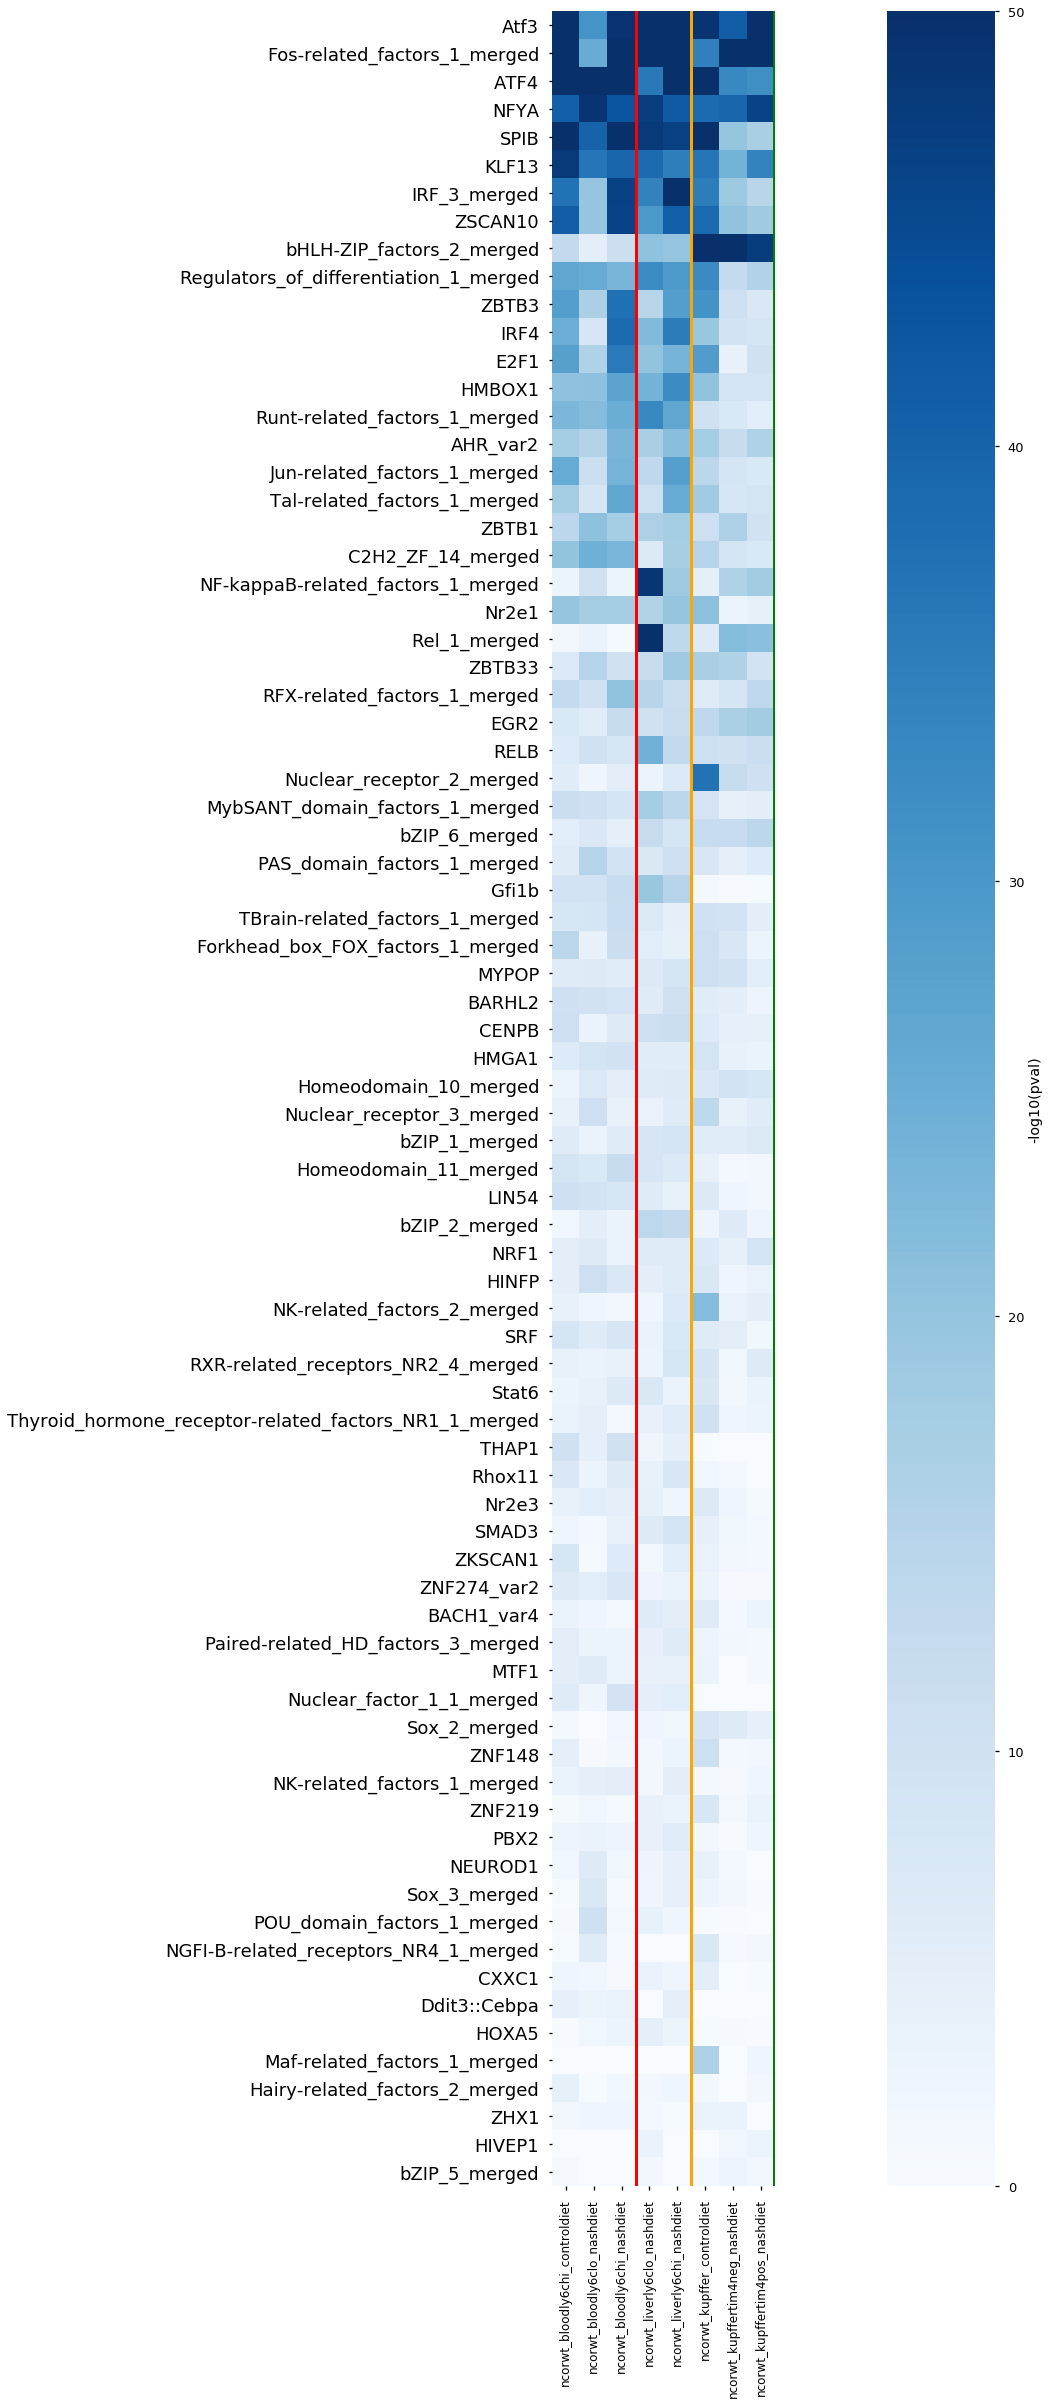

In [21]:
pseudocount = 1e-50 # pseudocount for calculating logfold change
treatments = mean_pval_frame.columns
# treatment_orientedPvals_dict = {}
for treatment in treatments:
    # retrieve pval and weights cooresponding to treatment
    pvals = mean_pval_frame[treatment]
    weights = mean_weights_frame[treatment]
    
    # calculate logpvals and assign direction according to weight
    oriented_pvals = [np.log10(x[0] +pseudocount) if x[1] < 0 else -np.log10(x[0]+pseudocount) for x in zip(pvals, weights)]
    treatment_orientedPvals_dict[treatment] = oriented_pvals

    
# create data frame
frame = pd.DataFrame(treatment_orientedPvals_dict, index = mean_pval_frame.index.values)
# sort by mean
frame['mean'] = frame.mean(axis=1)
frame.sort_values('mean', ascending = False, inplace=True)
frame.drop('mean', axis=1, inplace=True)

# plot only motifs with log pval > 2 for at least one condition (p<0.01) and positively correlated with open chromatin
frame = frame[frame.max(axis=1) > 2]
# plot only motifs with absolute log likelihood ratio >=4
filtered_frame = frame[((frame.max(axis=1) - frame.min(axis=1)).abs() >=4)]
filtered_frame = filtered_frame.loc[:, samp_order]

# create heatmap
fig, ax = plt.subplots(figsize=(40,40))
hm = sns.heatmap(
    filtered_frame,
    vmin=0,
    cmap='Blues',
    cbar_kws={'label': '-log10(pval)'},
    square=True,
    ax=ax)
pos = hm.get_position()

hm.set_yticklabels(size=18, labels = [i[:100] for i in filtered_frame.index.values]);
hm.set_xticklabels(size=12, labels = filtered_frame.columns.values, rotation=90);

# draw lines to separate groups
# plt.plot([.1, .1], [0, 100], linewidth=3, color='r');
plt.plot([3, 3], [0, 100], linewidth=3, color='r');
plt.plot([5, 5], [0, 100], linewidth=3, color='orange');
plt.plot([7.95, 7.95], [0, 100], linewidth=3, color='green');

plt.savefig('./figures/tba_differential_motif_heatmap_all_tfs.pdf',bbox_inches='tight')

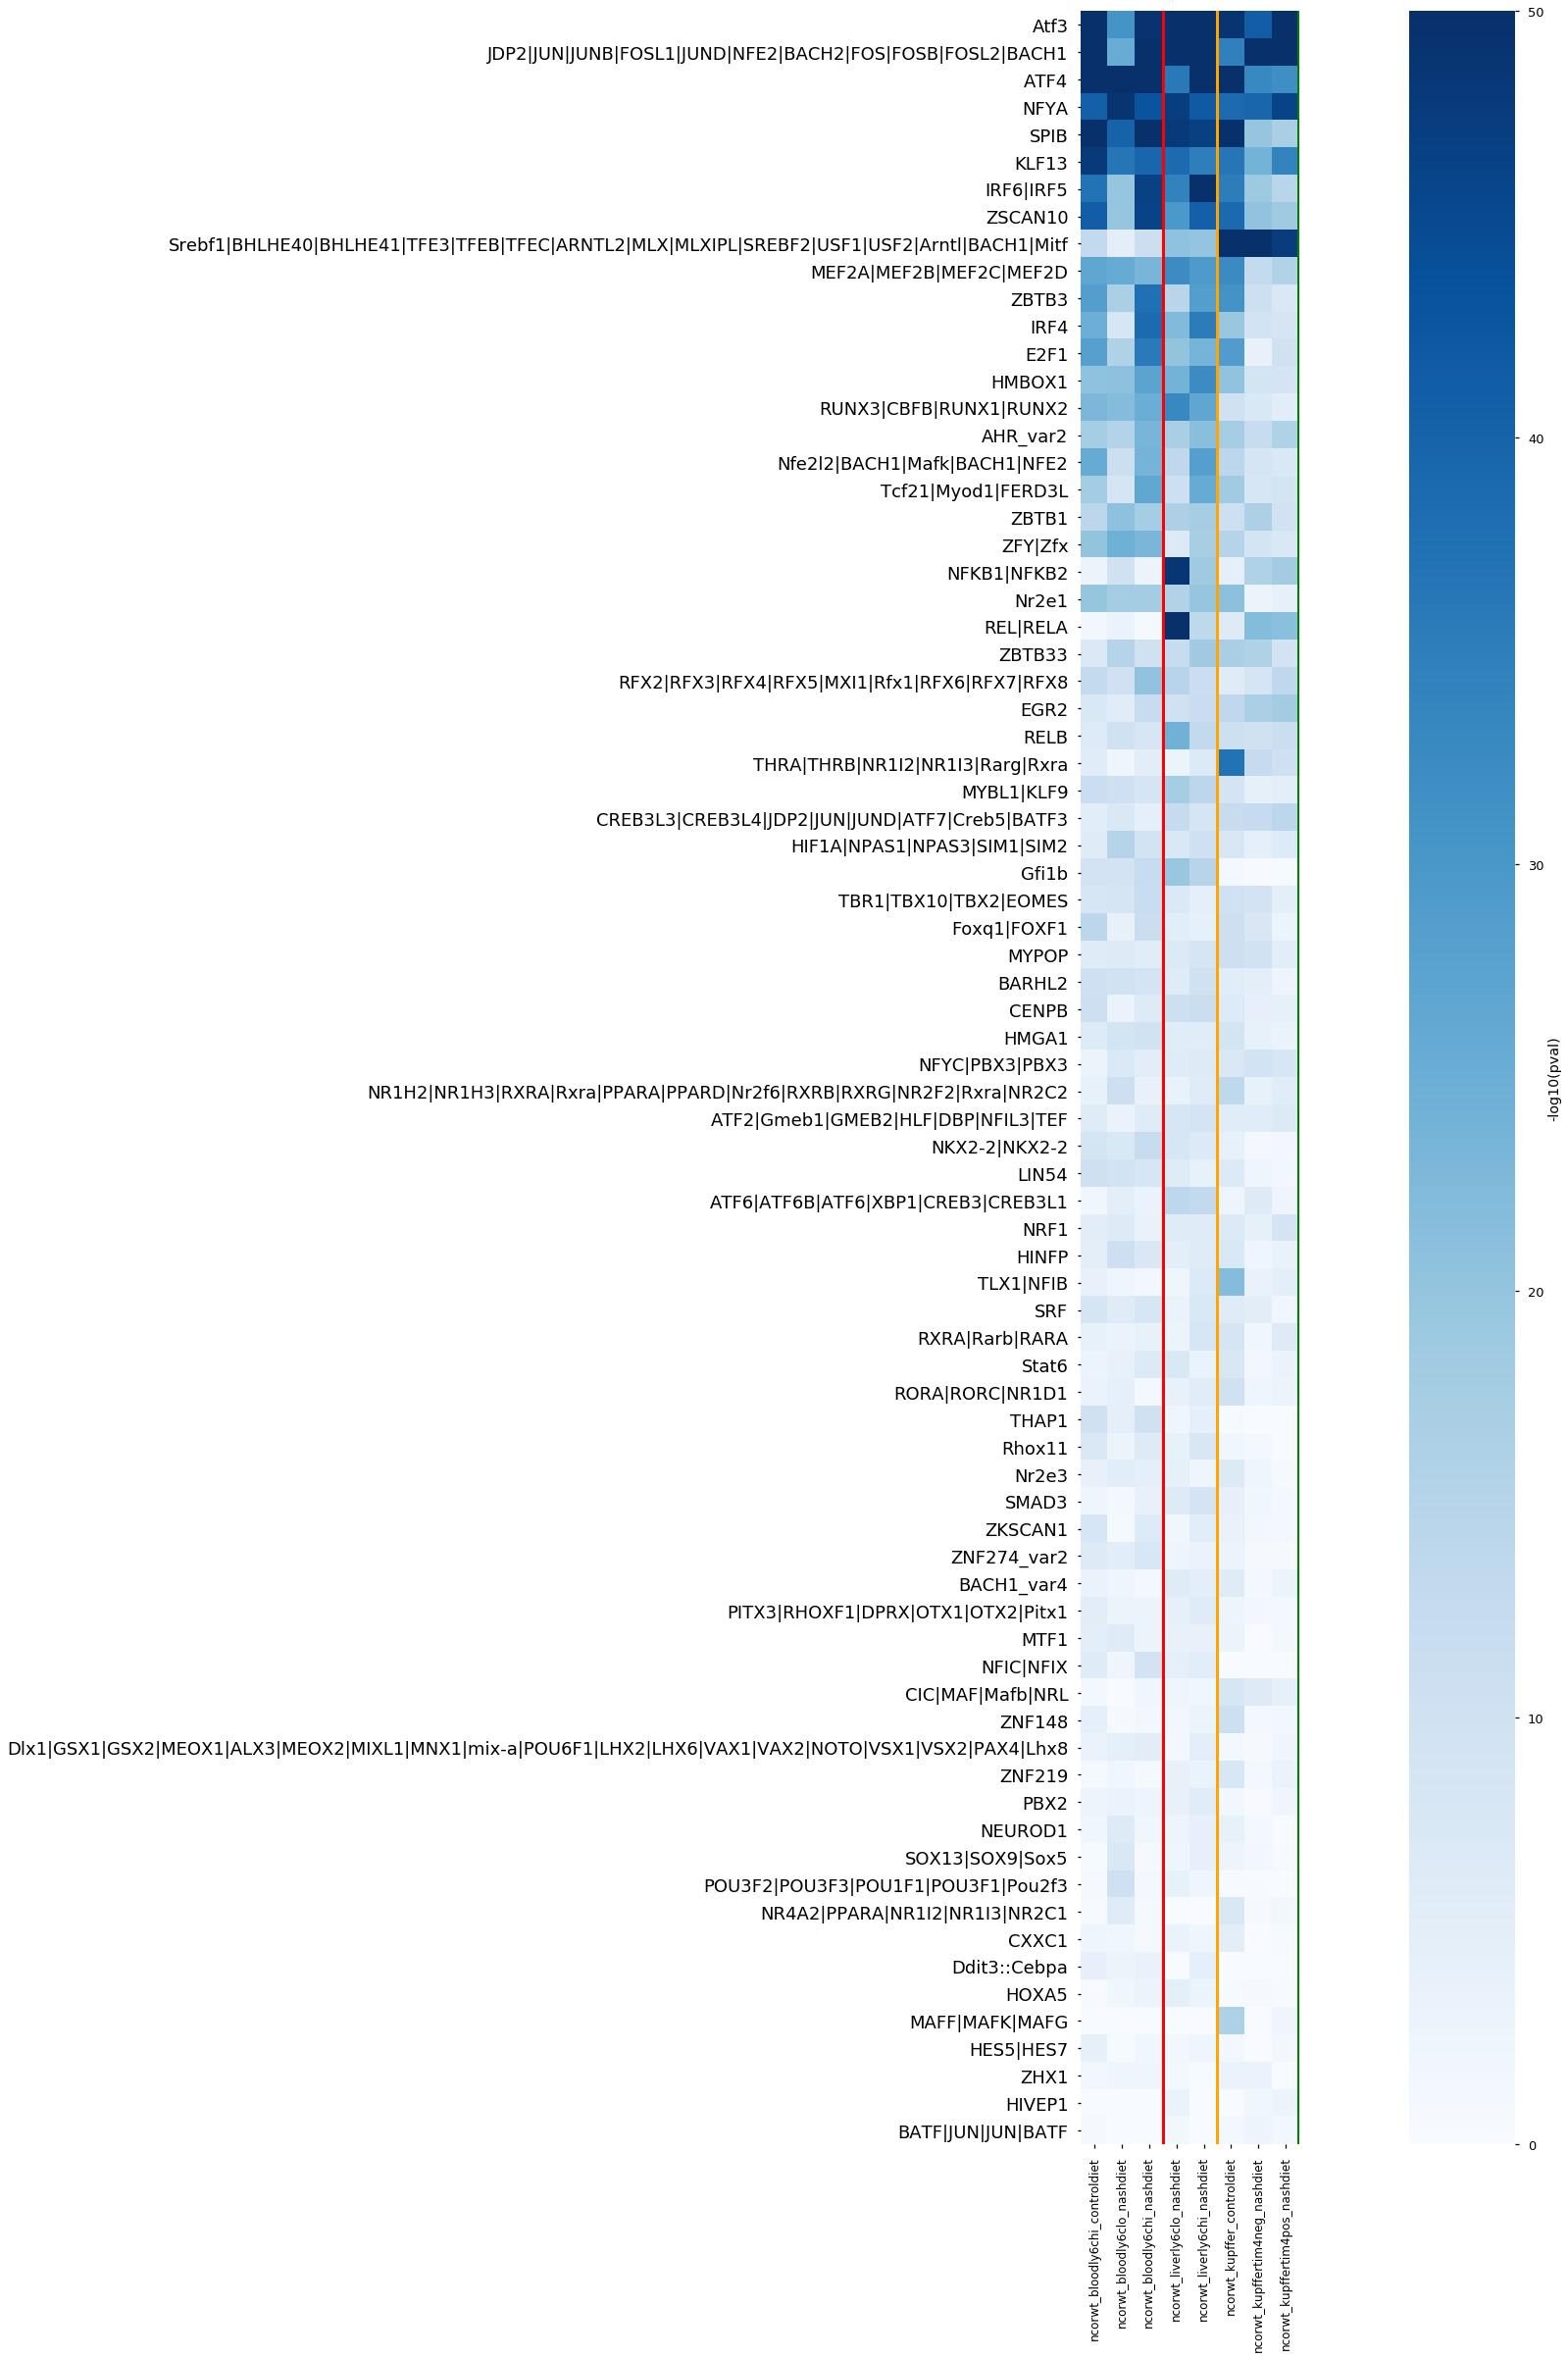

In [24]:
pseudocount = 1e-50 # pseudocount for calculating logfold change
treatments = mean_pval_frame.columns
# treatment_orientedPvals_dict = {}
for treatment in treatments:
    # retrieve pval and weights cooresponding to treatment
    pvals = mean_pval_frame[treatment]
    weights = mean_weights_frame[treatment]
    
    # calculate logpvals and assign direction according to weight
    oriented_pvals = [np.log10(x[0] +pseudocount) if x[1] < 0 else -np.log10(x[0]+pseudocount) for x in zip(pvals, weights)]
    treatment_orientedPvals_dict[treatment] = oriented_pvals

# create data frame
frame = pd.DataFrame(treatment_orientedPvals_dict, index = mean_pval_frame.index.values)
tba_frame = frame
# sort by mean
frame['mean'] = frame.mean(axis=1)
frame.sort_values('mean', ascending = False, inplace=True)
frame.drop('mean', axis=1, inplace=True)

# plot only motifs with log pval > 2 for at least one condition (p<0.01) and positively correlated with open chromatin
frame = frame[frame.max(axis=1) > 2]
# plot only motifs with absolute log likelihood ratio >=4
filtered_frame = frame[((frame.max(axis=1) - frame.min(axis=1)).abs() >=4)]
filtered_frame = filtered_frame.loc[:, samp_order]
filtered_frame = filtered_frame.rename(merged_motif_dict, axis='index')

# create heatmap
fig, ax = plt.subplots(figsize=(40,40))
hm = sns.heatmap(
    filtered_frame,
    vmin=0,
    cmap='Blues',
    cbar_kws={'label': '-log10(pval)'},
    square=True,
    ax=ax)
pos = hm.get_position()

hm.set_yticklabels(size=18, labels = [i[:100] for i in filtered_frame.index.values]);
hm.set_xticklabels(size=12, labels = filtered_frame.columns.values, rotation=90);

# draw lines to separate groups
# plt.plot([.1, .1], [0, 100], linewidth=3, color='r');
plt.plot([3, 3], [0, 100], linewidth=3, color='r');
plt.plot([5, 5], [0, 100], linewidth=3, color='orange');
plt.plot([7.95, 7.95], [0, 100], linewidth=3, color='green');


plt.savefig('./figures/tba_differential_motif_heatmap.pdf',bbox_inches='tight')

## Compare HOMER Results to TBA

### Most apt comparison is the known motif analysis approach

In [12]:
%%bash
# delete the existing script file
rm ./run_knownmotif.sh
# create a script file
touch ./run_knownmotif.sh

# if directories don't exist, create them
if [ ! -d ./known_motif/ ]; then mkdir ./known_motif; fi

for peak_file in ./atac_idr_peaks/*;

do motif_file=${peak_file/atac_idr_peaks.tsv/known_motif_enrichment}
motif_file=${motif_file/atac_idr_peaks/known_motif}
echo "findMotifsGenome.pl $peak_file mm10 $motif_file -size 200 -nomotif &" >> run_knownmotif.sh
done

### Read in known motif significance values

In [77]:
known_motif_pval_dict = {}
for f in os.listdir('./known_motif/'):
#     with open('./known_motif/'+f+'/knownResults.txt', 'r') as j:
#         j.readline() # skip first line
#         pval = [fields[2] for fields in j.readlines()]
    
    # read in signifance values using pandas
    frame = pd.read_csv('./known_motif/'+f+'/knownResults.txt', sep='\t', index_col=0)
    # remove duplicates
    frame = frame[~frame.index.duplicated(keep='first')]
    pval = frame.iloc[:, 1]
    sample = '_'.join(f.split('_')[0:3])
    known_motif_pval_dict[sample] = pval
# create data frame
known_motif_pval_frame = pd.DataFrame(known_motif_pval_dict)

### Top 20 by known motif

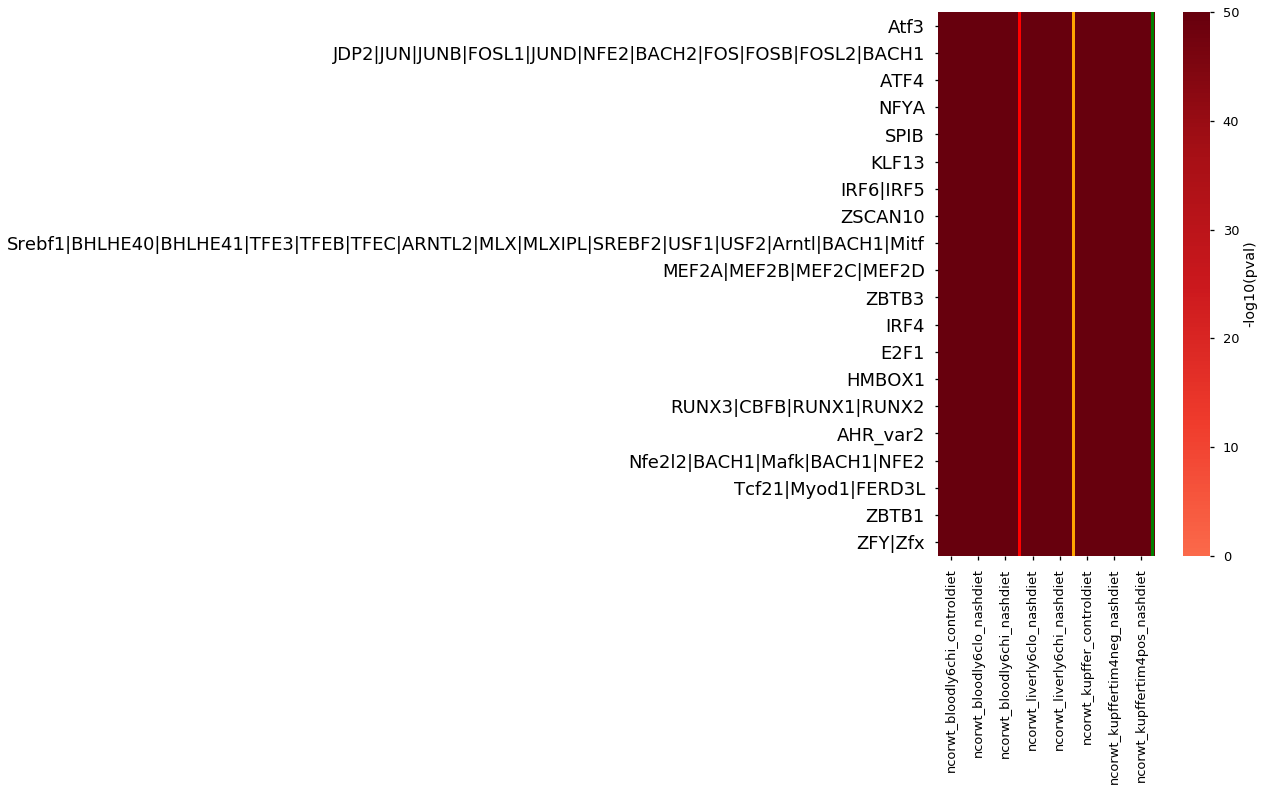

In [91]:
pseudocount = 1e-50 # pseudocount for calculating logfold change
treatments = known_motif_pval_frame.columns
treatment_orientedPvals_dict = {}
for treatment in treatments:
    # retrieve pval and weights cooresponding to treatment
    pvals = known_motif_pval_frame[treatment]
    # calculate logpvals and assign direction according to weight
    oriented_pvals = [-np.log10(float(x)+pseudocount) for x in pvals]
    treatment_orientedPvals_dict[treatment] = oriented_pvals

# create data frame
frame = pd.DataFrame(treatment_orientedPvals_dict, index = known_motif_pval_frame.index.tolist())
homer_frame = frame
homer_frame.to_csv('./tf_mean_pval_homer.tsv', sep='\t')

# sort by mean
frame['mean'] = frame.mean(axis=1)
frame.sort_values('mean', ascending = False, inplace=True)
frame.drop('mean', axis=1, inplace=True)

frame = frame.iloc[:20, :].loc[:, samp_order]

# create heatmap
fig, ax = plt.subplots(figsize=(10,10))
hm = sns.heatmap(
    frame,
    center=0,
    vmin=0,
    cbar_kws={'label': '-log10(pval)'},
    square=True,
    cmap='Reds',
    ax=ax)
pos = hm.get_position()

hm.set_yticklabels(size=18, labels = [i.split('/')[0] for i in filtered_frame.index.values]);

# draw lines to separate groups
# plt.plot([.1, .1], [0, 100], linewidth=3, color='r');
plt.plot([3, 3], [0, 100], linewidth=3, color='r');
plt.plot([5, 5], [0, 100], linewidth=3, color='orange');
plt.plot([7.9, 7.9], [0, 100], linewidth=3, color='green');

plt.savefig('./figures/tba_top20_motif_heatmap.pdf',bbox_inches='tight')

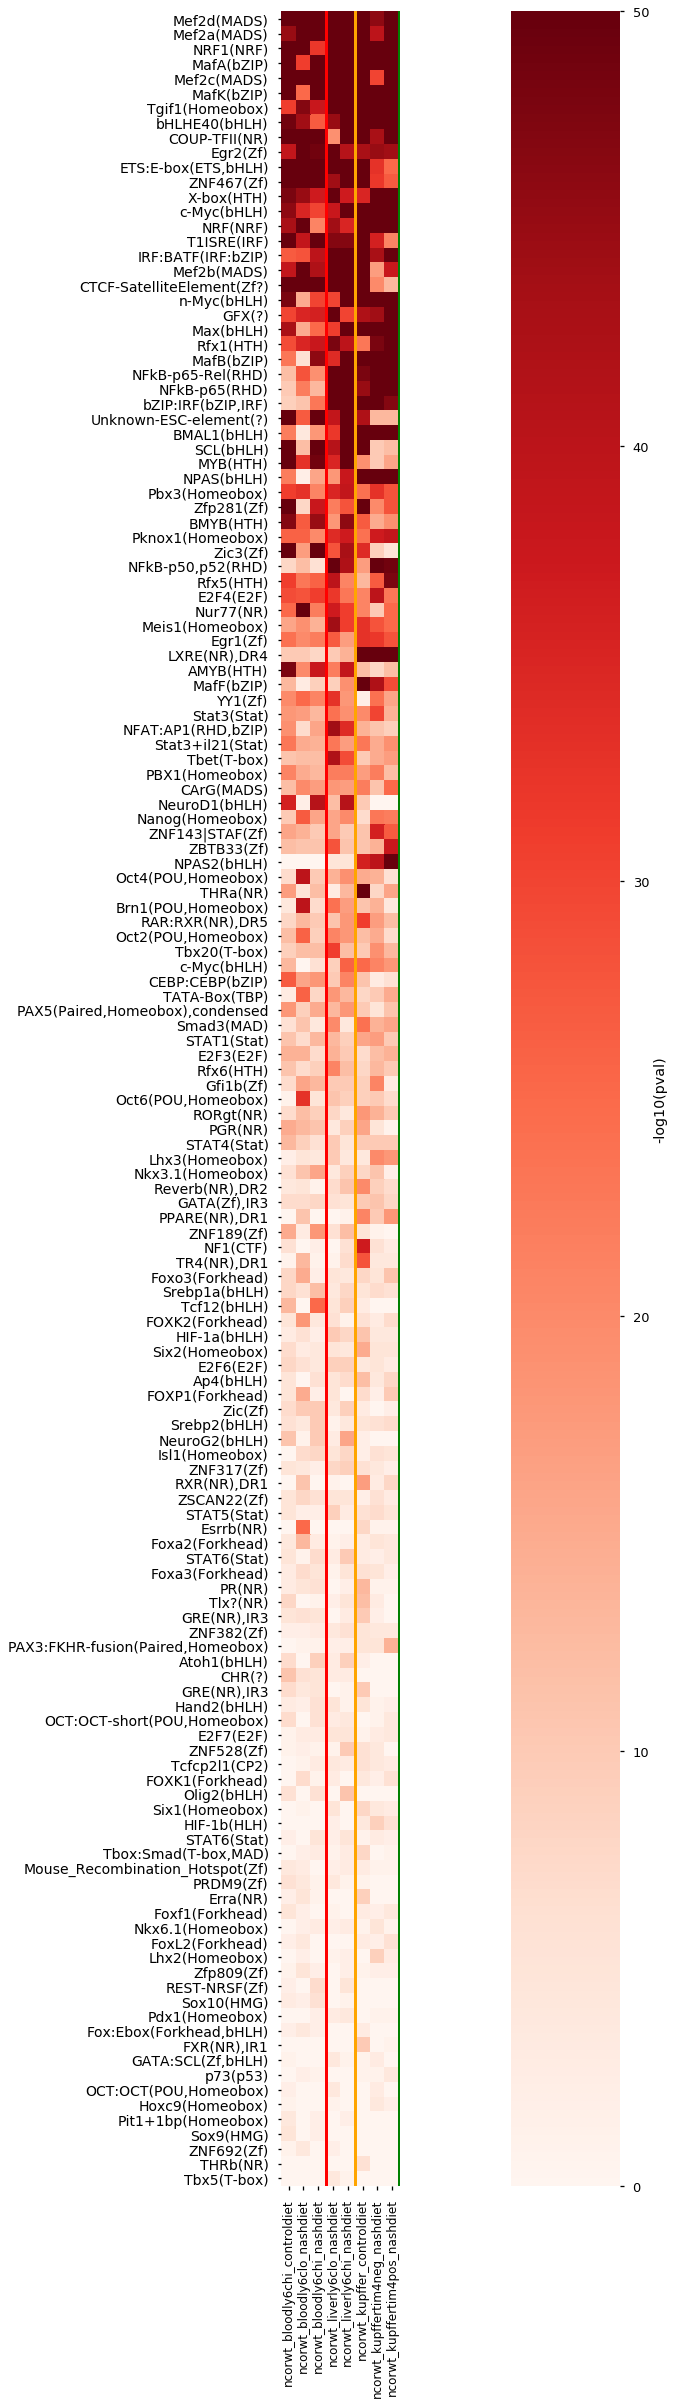

In [20]:
pseudocount = 1e-50 # pseudocount for calculating logfold change
treatments = mean_pval_frame.columns
# treatment_orientedPvals_dict = {}
for treatment in treatments:
    # retrieve pval and weights cooresponding to treatment
    pvals = known_motif_pval_frame[treatment]
    
    # calculate logpvals and assign direction according to weight
    oriented_pvals = [-np.log10(float(x)+pseudocount) for x in pvals]
    treatment_orientedPvals_dict[treatment] = oriented_pvals

# create data frame
frame = pd.DataFrame(treatment_orientedPvals_dict, index = known_motif_pval_frame.index.values)
# sort by mean
frame['mean'] = frame.mean(axis=1)
frame.sort_values('mean', ascending = False, inplace=True)
frame.drop('mean', axis=1, inplace=True)

# plot only motifs with log pval > 2 for at least one condition (p<0.01) and positively correlated with open chromatin
frame = frame[frame.max(axis=1) > 2]
# plot only motifs with absolute log likelihood ratio >=4
filtered_frame = frame[((frame.max(axis=1) - frame.min(axis=1)).abs() >=4)]
filtered_frame = filtered_frame.loc[:, samp_order]
filtered_frame = filtered_frame.rename(merged_motif_dict, axis='index')

# create heatmap
fig, ax = plt.subplots(figsize=(40,40))
hm = sns.heatmap(
    filtered_frame,
    vmin=0,
    cmap='Reds',
    cbar_kws={'label': '-log10(pval)'},
    square=True,
    ax=ax)
pos = hm.get_position()

hm.set_yticklabels(size=14, labels = [i.split('/')[0] for i in filtered_frame.index.values]);
hm.set_xticklabels(size=12, labels = filtered_frame.columns.values, rotation=90);

# draw lines to separate groups
# plt.plot([.1, .1], [0, 100], linewidth=3, color='r');
plt.plot([3, 3], [0, 300], linewidth=3, color='r');
plt.plot([5, 5], [0, 300], linewidth=3, color='orange');
plt.plot([7.95, 7.95], [0, 300], linewidth=3, color='green');


plt.savefig('./figures/homer_differential_motif_heatmap_all_tfs.pdf',bbox_inches='tight')

### Try to combine homer and tba

Convert homer index so it is just TF names

In [147]:
homer_frame = pd.read_csv('./tf_mean_pval_homer.tsv', sep='\t', index_col=0)
homer_frame.index = homer_frame.index.to_series().str.split('(').str[0].str.upper()
homer_frame.rename(index={'NFKB-P65':'NFKB2', 'NFKB-P50,P52':'NFKB1', 'LXRE':'NR1H3'}, inplace=True)

Import TF indexed TBA scores

In [143]:
tf_mean_pval_frame = pd.read_csv('./tf_mean_pval.tsv', sep='\t', index_col=0)
tf_mean_weight_frame = pd.read_csv('./tf_mean_pval.tsv', sep='\t', index_col=0)

pseudocount = 1e-50 # pseudocount for calculating logfold change
treatments = tf_mean_pval_frame.columns
treatment_orientedPvals_dict = {}
# create treatement oriented p val frame
for treatment in treatments:
    # retrieve pval and weights cooresponding to treatment
    pvals = tf_mean_pval_frame[treatment]
    weights = tf_mean_weight_frame[treatment]
    # calculate logpvals and assign direction according to weight
    oriented_pvals = [np.log10(x[0] +pseudocount) if x[1] < 0 else -np.log10(x[0]+pseudocount) for x in zip(pvals, weights)]
    # store in dict
    treatment_orientedPvals_dict[treatment] = oriented_pvals

# create data frame
tf_frame = pd.DataFrame(treatment_orientedPvals_dict, index = tf_mean_pval_frame.index.values)

Try with merged dataframe

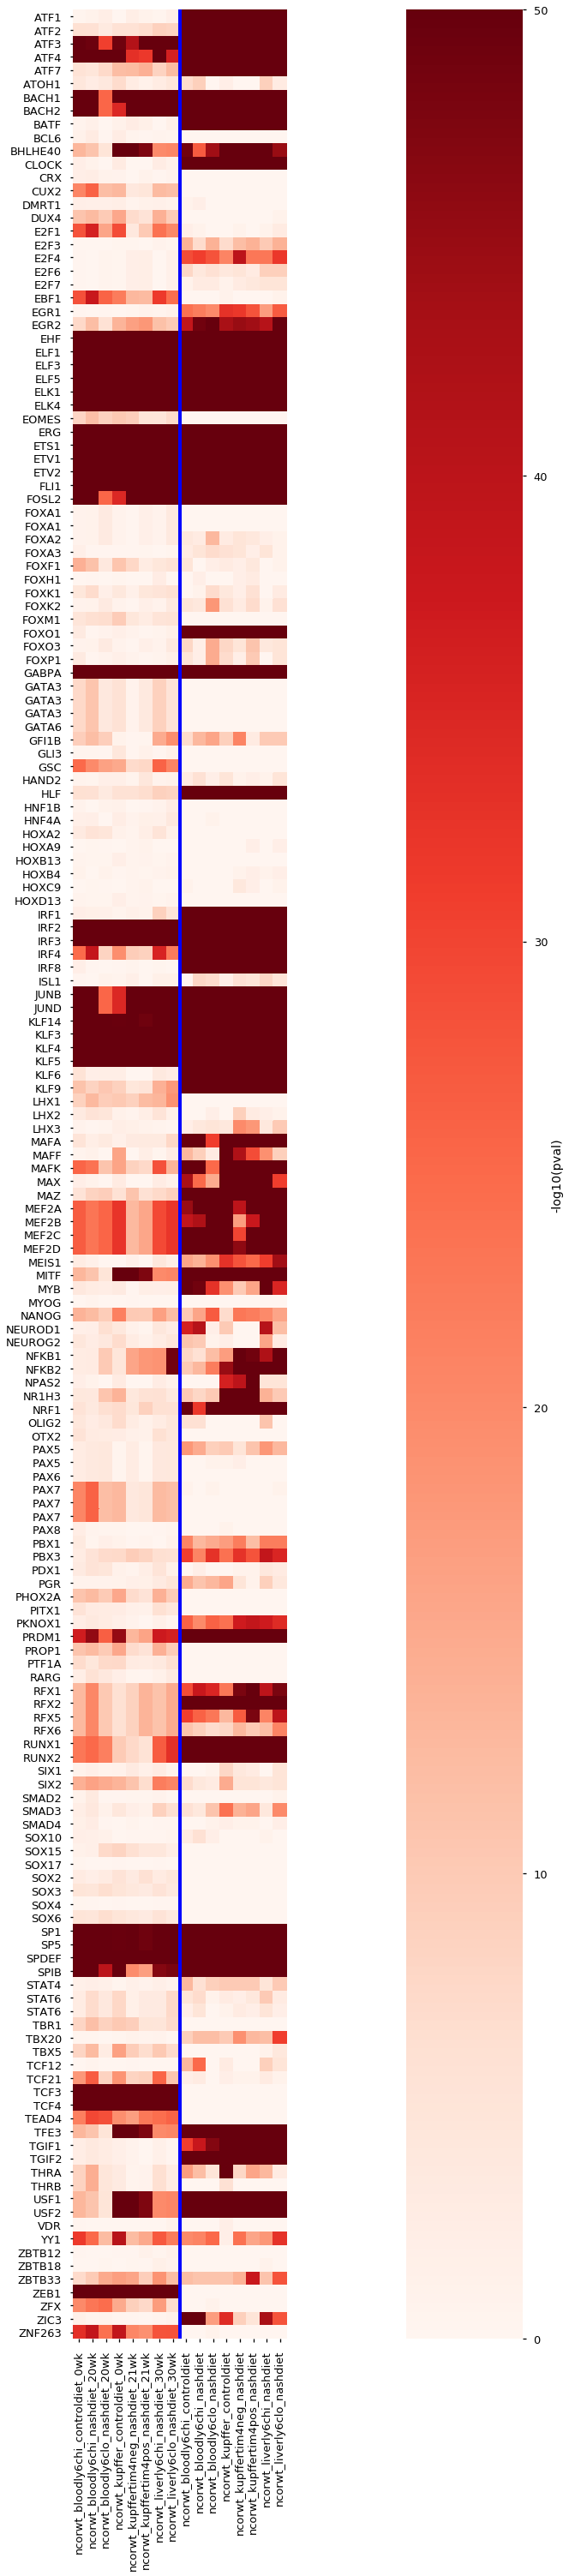

In [149]:
tba_homer = tf_frame.merge(
    homer_frame,
    left_index=True,
    right_index=True,
    how='inner')

fig, ax = plt.subplots(figsize=(50, 50))
hm = sns.heatmap(
    tba_homer,
    cmap='Reds',
    square=True,
    cbar_kws={'label': '-log10(pval)'},)

plt.plot([8, 8], [0, 300], linewidth=4, color='b');